In [1]:
import h5py
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR
import sys
from tqdm.auto import tqdm

sys.path.append('/om2/user/eisenaj/code/repos/local-linear-segmentation/segmentation_code')
import LLSA as lvar
import LLSA_calculations as lvarc

sys.path.append('../..')
from utils import load, save

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
dt = 1/128

# load all data

In [4]:
data_dir = '/om/user/eisenaj/datasets/DASPS_Database/'

In [5]:
response_df = pd.read_excel(os.path.join(data_dir, 'participant_rating_public.xlsx'))
response_df = response_df.drop('Unnamed: 0', axis=1)

In [6]:
response_df['anxious'] = [None]*len(response_df)
anxious = np.zeros((23, 6))
anxiety_level = np.zeros((23, 6))
response_df['anxiety_level'] = [None]*len(response_df)
for i in range(len(response_df)):
    if not isinstance(response_df.loc[i]['Id Participant'], str):
        response_df.loc[i, 'Id Participant'] = response_df.loc[i - 1]['Id Participant']
        response_df.loc[i, 'Hmilton1'] = response_df.loc[i-1, 'Hmilton1']
        response_df.loc[i, 'Hamilton2'] = response_df.loc[i-1, 'Hamilton2']
        response_df.loc[i, 'Situation provocante'] = response_df.loc[i - 1, 'Situation provocante']
    subject_num = int(response_df.loc[i, "Id Participant"][1:])
    situation_num = int(response_df.loc[i, "Id situation "])
    
    valence = response_df.loc[i,'valence']
    arousal = response_df.loc[i, 'Arousal']
    response_df.loc[i, 'anxious'] = True if valence < 5 and arousal > 5 else False
    
    
    if not response_df.loc[i, 'anxious']:
        response_df.loc[i, 'anxiety_level'] = None
        anxious[subject_num-1, situation_num-1] = 0
        anxiety_level[subject_num-1, situation_num-1] = 0
    else:
        anxious[subject_num-1, situation_num-1] = 1
        if valence in [0, 1, 2] and arousal in [7, 8, 9]:
            response_df.loc[i, 'anxiety_level'] = 'severe'
            anxiety_level[subject_num-1, situation_num-1] = 4
        elif valence in [2, 3, 4] and arousal in [6, 7]:
            response_df.loc[i, 'anxiety_level'] = 'moderate'
            anxiety_level[subject_num-1, situation_num-1] = 2
        elif valence in [4, 5] and arousal in [5, 6]:
            response_df.loc[i, 'anxiety_level'] = 'light'
            anxiety_level[subject_num-1, situation_num-1] = 1
        else:
            response_df.loc[i, 'anxiety_level'] = 'normal'
            anxiety_level[subject_num-1, situation_num-1] = 3

In [7]:
data = np.zeros((23, 6, 30*128, 14))
for subject_num in range(1, 24):
    for situation_num in range(1, 7):
        f = h5py.File(os.path.join(data_dir, f"Preprocessed data .mat/S{subject_num:02d}preprocessed.mat"), 'r')
#         f = h5py.File(os.path.join(data_dir, f"Raw data.mat/S{subject_num:02d}.mat", 'r'))
        t = np.arange(f['data'].shape[1]*2)*dt
        data[subject_num-1, situation_num-1] = np.vstack([f['data'][(situation_num-1)*2, :, :], f['data'][(situation_num-1)*2 + 1, :, :]])

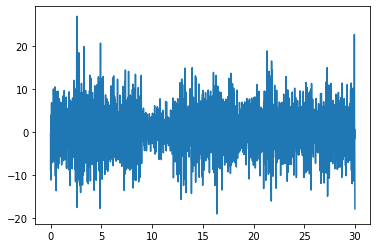

In [8]:
subject_num = 5
situation_num = 1
electrode_num = 0
plt.plot(np.arange(0, 30, 1/128), data[subject_num-1, situation_num-1, :, electrode_num])
# plt.plot(butter_bandpass_filter(data[subject_num-1, situation_num-1, :, electrode_num], 0.4, 50, fs=1/dt))
plt.show()

In [9]:
area = 'frontal'
if area == 'all':
    area_inds = np.arange(14)
elif area == 'frontal':
    area_inds = np.arange(8)
else:
    raise ValueError(f"Area {area} is not allowed!")

## Check Data Conditioning

In [24]:
# minimum_window_options = [0.5, 0.75, 1]
n_test_windows = 20

# minimum_window_options = np.arange(0.5, 2, 0.1)
minimum_window_options = np.arange(0.1, 1, 0.05)
# n_test_windows = 1200

num_subjects = 23
num_trials = 6

conds_w = np.zeros((num_subjects, num_trials, len(minimum_window_options), n_test_windows))
conds_cov_w = np.zeros(conds_w.shape)

iterator = tqdm(total=np.prod(conds_w.shape))
for subject_ind in range(num_subjects):
    for trial_ind in range(num_trials):
    
        for i, window_seconds in enumerate(minimum_window_options):
            window = int(window_seconds/dt)
            for j in range(n_test_windows):
                start_t = np.random.randint(0, data.shape[2] - window)
                window_data = data[subject_ind, trial_ind, start_t:start_t + window, area_inds]
                window_data = window_data.T
                conds_w[subject_ind, trial_ind, i, j] = np.linalg.cond(np.cov(window_data.T))

        #         # statsmodels.tsa.api
        #         model = VAR(window_data)
        #         VAR_results = model.fit(1)
        #         inter, coef, cov = VAR_results.intercept, VAR_results.coefs[0], VAR_results.sigma_u

                # cython implementation
                theta,eps=lvarc.get_theta(window_data,1)
                inter,coef,cov=lvarc.decomposed_theta(theta)
                coef = coef.T

                conds_cov_w[subject_ind, trial_ind, i, j] = np.linalg.cond(cov)

                iterator.update()
iterator.close()

conds_w = np.swapaxes(conds_w, 0, 2)
conds_w = conds_w.reshape(conds_w.shape[0], conds_w.shape[1]*conds_w.shape[2]*conds_w.shape[3])
conds_cov_w = np.swapaxes(conds_cov_w, 0, 2)
conds_cov_w = conds_cov_w.reshape(conds_cov_w.shape[0], conds_cov_w.shape[1]*conds_cov_w.shape[2]*conds_cov_w.shape[3])

  0%|          | 0/49680 [00:00<?, ?it/s]

In [25]:
def bootstrap(l,n_times,n_samples=1000,confidence_interval=95):
    if n_samples>len(l):
        n_samples=len(l)*2
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),n_samples)#len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(np.median(new_list,axis=0))
    new_means=np.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.percentile(new_means[:,i],per)
        ciu[i]=np.percentile(new_means[:,i],100-per)
    return np.median(l,axis=0),cil,ciu

In [26]:
median_w=[]
median_cil_w=[]
median_ciu_w=[]
median_cov_w=[]
median_cil_cov_w=[]
median_ciu_cov_w=[]
for k in tqdm(range(conds_w.shape[0])):
    median,cil,ciu=bootstrap(conds_w[k], n_test_windows)
    median_w.append(median)
    median_cil_w.append(cil)
    median_ciu_w.append(ciu)
    median,cil,ciu=bootstrap(conds_cov_w[k], n_test_windows)
    median_cov_w.append(median)
    median_cil_cov_w.append(cil)
    median_ciu_cov_w.append(ciu)

  0%|          | 0/18 [00:00<?, ?it/s]

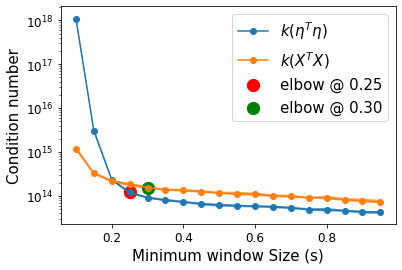

In [27]:
plt.plot(minimum_window_options,np.hstack(median_cov_w),marker='o',label='$k(\eta^T\eta)$')
plt.fill_between(minimum_window_options,np.hstack(median_cil_cov_w),np.hstack(median_ciu_cov_w),alpha=.7)
plt.plot(minimum_window_options,np.hstack(median_w),marker='o',label='$k(X^TX)$')
plt.fill_between(minimum_window_options,np.hstack(median_cil_w),np.hstack(median_ciu_w),alpha=.7)
# kneedle = KneeLocator(minimum_window_options, median_cov_w, S=2, curve='convex', direction='decreasing')
# plt.scatter(kneedle.elbow, kneedle.elbow_y, c='red', marker='o', label='elbow', s=150)
kneedle = KneeLocator(minimum_window_options, np.log10(median_cov_w), S=2, curve='convex', direction='decreasing')
plt.scatter(kneedle.elbow, np.power(10, kneedle.elbow_y), c='red', marker='o', label=f'elbow @ {kneedle.elbow:.2f}', s=150)
kneedle2 = KneeLocator(minimum_window_options, np.log10(median_w), S=2, curve='convex', direction='decreasing')
plt.scatter(kneedle2.elbow, np.power(10, kneedle2.elbow_y), c='green', marker='o', label=f'elbow @ {kneedle2.elbow:.2f}', s=150)
plt.ylabel('Condition number',fontsize=15)
plt.xlabel('Minimum window Size (s)',fontsize=15)
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim(guess_dims,20)
plt.legend(fontsize=15)
plt.show()

In [29]:
# the value of w0 should be guided by the previous plot
# stop when you get to more than 10 times as big as w0
w0=0.30
step_fraction=.25
i=w0
window_options=[]
while i < np.inf:
    window_options.append(i)
    step=i*step_fraction
    if int(i*step_fraction)>w0:
        break
    i+=step
print(f"window_options = {[float(f'{w:.3f}') for w in window_options]}")

window_options = [0.3, 0.375, 0.469, 0.586, 0.732, 0.916, 1.144, 1.431, 1.788, 2.235, 2.794, 3.492, 4.366]


# Adaptive segmentation

As discussed in the SegmentingHO.ipynb notebook, there are plenty of places along our pipeline where we can get a significant speed up by parallelizing the calculations. In this toy example, we haven't explicitly done any parallel calculation, as the nature of the parallelization will be specific to the data and the purpose of the analysis. A few examples of parallelizable parts include:

1) Likelihood ratio distribution: we need to do the exact same calculation N times

2) Parallelize over different time series, or pre-split the time series into chunks and parallelize over them

3) In the calculation of the distance matrix we can both parallelize one of the loops and also only compute the upper triangular or lower triangular matrix since, by construction, the matrix will be symmetric

In [30]:
N=50
per=97.5
cond_thresh = np.power(10, np.ceil(kneedle.elbow_y))
window_options_ms = [int(w/dt) for w in window_options]

results = [] 

iterator = tqdm(total=num_subjects*num_trials)
for subject_ind in range(num_subjects):
    for trial_ind in range(num_trials):
        
        sample_tseries = data[subject_ind, trial_ind]
        
        #apply segmentation algorithm
        breaks_segments=lvar.change_point(window_options_ms,N,per,np.ma.array(sample_tseries),20,cond_thresh=cond_thresh, verbose=True) 
        #cond_thresh is chosen in accordance to the condition number plot
        
        windows_segment,segments=breaks_segments
        #compute thetas in the obtained windows_segment
        thetas_final=[]
        for idx,seg in enumerate(segments):
            segment_windows=np.copy(windows_segment[idx])
            segments_windows=list(segment_windows)
            thetas=[]
            for seg_w in segment_windows:
                i_0,i_f=seg_w
                window_bw=sample_tseries[i_0:i_f]
                theta,eps=lvarc.get_theta(window_bw,1)
                thetas.append(np.vstack(theta))
            thetas_final.append(thetas)
        thetas_final=np.concatenate(thetas_final)
        windows_final=np.concatenate(windows_segment)
        
        criticality_indices = np.zeros((len(windows_final), data.shape[-1]))
        for i, theta in enumerate(thetas_final):
            c,A,cov=lvarc.decomposed_theta(theta)
            A = A.T
            e = np.linalg.eigvals(A)
            criticality_indices[i] = np.abs(e)
        #     coef=(A-np.identity(theta.shape[1]))*frameRate
        #     all_eigs.append(np.linalg.eigvals(coef))
        
        results.append(dict(
            windows_final = windows_final,
            thetas_final = thetas_final,
            criticality_indices = criticality_indices,
            subject_ind = subject_ind,
            subject_num = subject_ind + 1,
            trial_ind = trial_ind,
            situation_num = trial_ind + 1
        ))
        iterator.update()

  0%|          | 0/138 [00:00<?, ?it/s]

Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

/om2/user/eisenaj/anaconda/envs/chaotic-consciousness/lib/python3.9/site-packages/numpy/lib/function_base.py:3964: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t>=0.5)


Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

/om2/user/eisenaj/anaconda/envs/chaotic-consciousness/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

/om2/user/eisenaj/anaconda/envs/chaotic-consciousness/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/om2/user/eisenaj/anaconda/envs/chaotic-consciousness/lib/python3.9/site-packages/numpy/linalg/linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...
Now segmenting the time series...


  0%|          | 0/3802 [00:00<?, ?it/s]

Removing artificial breaks...


In [31]:
save(results, os.path.join(data_dir, f'results_locallinearseg_{area}'))

# Load Results

In [10]:
results = load(os.path.join(data_dir, f'results_locallinearseg_{area}'))

In [11]:
results = pd.DataFrame(results)
extra_cols = []
for i, row in results.iterrows():
    response_row = response_df[np.logical_and(response_df['Id Participant'] == f"S{row.subject_num:02d}", response_df['Id situation '] == row.situation_num)].iloc[0]
    extra_cols.append(dict(
        valence=response_row.valence,
        arousal=response_row.Arousal,
        hamilton1=response_row.Hmilton1,
        hamilton2=response_row.Hamilton2,
        situation_provocante=response_row['Situation provocante'],
        anxious=response_row.anxious,
        anxiety_level=response_row.anxiety_level
    ))
results_df = pd.concat([results, pd.DataFrame(extra_cols)], axis=1)

In [12]:
drop_inds = []
for i, row in results_df.iterrows():
    if row.criticality_indices.max() > 10:
        drop_inds.append(i)
results_df = results_df.drop(drop_inds)

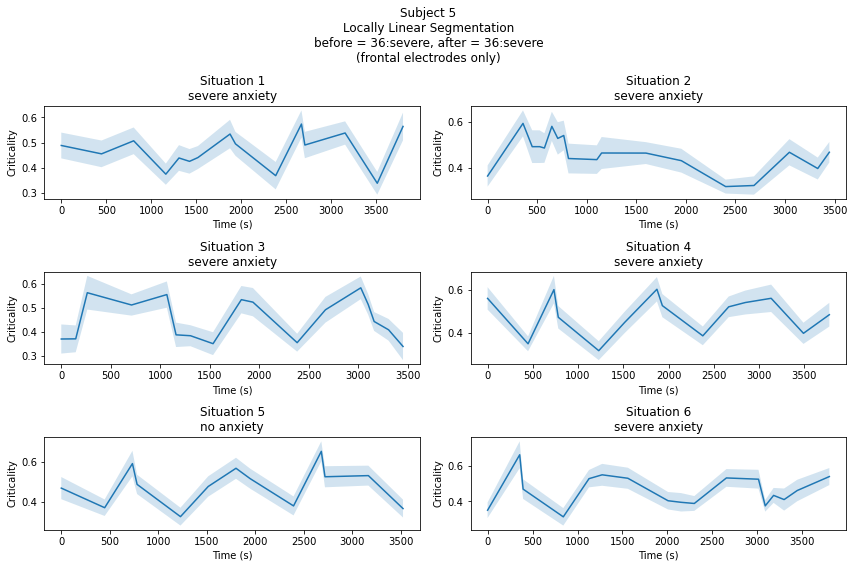

In [13]:
subject_num = 5

rows = 3
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

for situation_num in range(1, 7):
    ax = axs[int((situation_num - 1)/cols)][(situation_num - 1)%cols]
    row = results_df[np.logical_and(results_df.subject_num == subject_num, results_df.situation_num == situation_num)].iloc[0]
    t = row.windows_final[:, 0]
    mean_CIs = row.criticality_indices.mean(axis=1)
    stderr_CIs = row.criticality_indices.std(axis=1)/np.sqrt(row.criticality_indices.shape[1])
    ax.plot(t, mean_CIs)
    ax.fill_between(t, mean_CIs - stderr_CIs, mean_CIs + stderr_CIs, alpha=0.2)
    ax.set_xlabel("Time (s)")
    anxiety_add_on = f"{row.anxiety_level} anxiety" if row.anxious else "no anxiety"
    ax.set_title(f"Situation {situation_num}\n{anxiety_add_on}")
    ax.set_ylabel("Criticality")
plt.suptitle(f"Subject {subject_num}\nLocally Linear Segmentation\nbefore = {row.hamilton1}, after = {row.hamilton2}" + ("\n(frontal electrodes only)" if area == 'frontal' else "\nall electrodes"))
plt.tight_layout()
plt.show()

In [22]:
anxious_inds = []
normal_inds = []
for i, row in results_df.iterrows():
    if row.criticality_indices.max() < 3:
        if row.anxious:
            anxious_inds.extend(row.criticality_indices.flatten())
        else:
            normal_inds.extend(row.criticality_indices.flatten())
anxious_inds = np.array(anxious_inds)
normal_inds = np.array(normal_inds)

In [23]:
len(normal_inds), len(anxious_inds)

(16758, 16660)

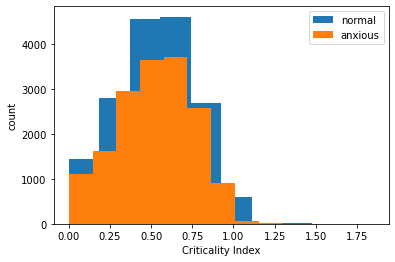

In [24]:
plt.hist(normal_inds, label='normal')
plt.hist(anxious_inds, label='anxious')
plt.xlabel("Criticality Index")
plt.ylabel("count")
plt.legend()
plt.show()

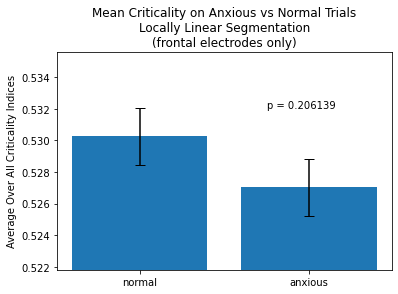

In [25]:
std_errors = [anxious_inds.std()/np.sqrt(len(anxious_inds)), normal_inds.std()/np.sqrt(len(normal_inds))]
mean_vals = [normal_inds.mean(), anxious_inds.mean()]
# t-test
n1 = len(anxious_inds)
n2 = len(normal_inds)
mean_1 = mean_vals[0]
mean_2 = mean_vals[1]
var_1 = (anxious_inds.std())**2
var_2 = (normal_inds.std())**2
s_squared = (n1 - 1)/(n1 + n2 - 2)*var_1 + (n2 - 1)/(n1 + n2 - 2)*var_2
t_stat = (mean_1 - mean_2)/(np.sqrt(s_squared)*np.sqrt((1/n1) + (1/n2)))
p = 2*scipy.stats.t.sf(t_stat, df=n1 + n2 - 2)

plt.bar(['normal', 'anxious'], mean_vals, yerr=std_errors, capsize=5)
plt.ylim([np.min(mean_vals)*(1/1.01), np.max(mean_vals)*(1.01)])
plt.text(0.75, mean_vals[0] + 1*std_errors[0], f"p = {p:.6f}" if p > 0.0001 else f"p = {p:.2e}")
plt.ylabel("Average Over All Criticality Indices")
plt.title(f"Mean Criticality on Anxious vs Normal Trials\nLocally Linear Segmentation" + ("\n(frontal electrodes only)" if area == 'frontal' else "\nall electrodes"))
plt.show()

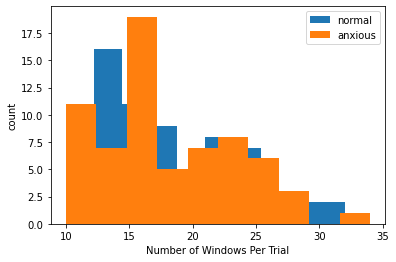

In [26]:
num_windows_anxious = results_df[results_df.anxious].criticality_indices.apply(lambda x: x.shape[0])
num_windows_normal = results_df[~results_df.anxious].criticality_indices.apply(lambda x: x.shape[0])
plt.hist(num_windows_normal, label='normal')
plt.hist(num_windows_anxious, label='anxious')
plt.xlabel("Number of Windows Per Trial")
plt.ylabel("count")
plt.legend()
plt.show()